In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import columnas_utils as col
import pandas as pd
%matplotlib inline
%matplotlib notebook

## Diseño de columnas de Concreto Armado

In [2]:
# Definicion de las unidades
N = 1
m = 1
cm = 1/100
Pa = 1
MPa = 10**6
pulg = 2.54 / 100

# Definicion de varillas de acero:
d_3 = 3/8 * pulg
d_4 = 1/4 * pulg
d_5 = 5/8 * pulg
d_6 = 3/4 * pulg
d_8 = 1 * pulg

A_3 = d_3 ** 2 /4 * math.pi
A_4 = d_4 ** 2 /4 * math.pi
A_5 = d_5 ** 2 /4 * math.pi
A_6 = d_6 ** 2 /4 * math.pi
A_8 = d_8 ** 2 /4 * math.pi

### Sección Transversal de la columna

In [3]:
b = 35*cm
h = 75*cm
r = 4*cm
column = col.Column(b, h, r)

### Datos de los materiales:

In [4]:
# Concreto
fc = 21*MPa #Resistencia a la compresion
eps_u = 0.003 #Deformación unitaria ultima
column.set_concrete(fc, eps_u)


#Acero
fy = 420*MPa #Esfuerzo a la fluencia del acero
Es = 200000*MPa #Módulo de elasticidad del acero
eps_y = fy/Es #Deformación de fluencia del acero
column.set_steel_reb(fy, Es)

## Refuerzo en la columna

In [5]:
d_p = d_5 #diámetro principal
d_s = d_5 #diámetro secundario
d_st = d_3 #diámetro del estribo
n_f = 6  #filas de acero
n_c = 3 #columnas de acero
column.set_rebar(d_p, d_s, d_st, n_f, n_c)

## Resistencia a la Compresión Pura

In [6]:
phi = 0.65
column.compress_resist(phi)

In [7]:
column.phiP_n

3016002.7986698234

## Rango de Iteración

In [8]:
#Definiendo el ángulo de rotacion de columna con respecto a la vertical
theta = math.radians(90)
#Rango de iteracion de a (borde de la columna)
l = b*math.cos(theta)+h*math.sin(theta)
#Definiendo puntos de iteración
a = np.array([i/100*l for i in range(101)])
#Vectores de altura al eje neutro:
c = a/column.betha

## Aporte de las barras

In [9]:
#Vector de distancias de cada barra (paralelo a las distancias a)
dist_vect_x_rot = column.dist_vect_x*math.cos(theta)
dist_vect_y_rot = column.dist_vect_y*math.sin(theta)
dist_matx = np.array([i+dist_vect_x_rot for i in dist_vect_y_rot])
dist_vect = dist_matx.flatten()

In [10]:
#Esfuerzos en cada barra de refuerzo:
matx_fs = np.array([[column.stress_f(c_i,x) for x in dist_vect] for c_i in c])

In [11]:
#distancia a las varillas extremas a tensión:
d_t = dist_vect.max()

#Valores de phi para cada valor de c
vect_phi = np.array([column.give_phi(d_t, c_i) for c_i in c])

In [12]:
#Aporte a la resistencia axial del acero:
rsp = np.dot(matx_fs,column.area_vect)

#Aporte a la resistencia de momento del acero:
dist_list_x = np.array([column.dist_vect_x for _ in column.dist_vect_y]).flatten()
dist_list_y = np.array([i for i in column.dist_vect_y for _ in column.dist_vect_x])
dist_CM_x = b/2-dist_list_x
dist_CM_y = h/2-dist_list_y
rsm_x = np.dot(matx_fs*column.area_vect,dist_CM_x)
rsm_y = np.dot(matx_fs*column.area_vect,dist_CM_y)

## Determinación de Fuerzas Resistentes

In [13]:
#Determinación del Area a compresion y su centroide:
A_X_Y = np.array([column.comp_area(theta,a_i) for a_i in a])
A_c = A_X_Y[:,0]
x_c = A_X_Y[:,1]
y_c = A_X_Y[:,2]

In [14]:
#Carga Axial Nominal
vect_Pn = np.array([0.85*fc*A_c[i]+rsp_i for i,rsp_i in enumerate(rsp) ])

#Carga Axial Reducida
phiP_n = column.phiP_n 
vect_phi_Pn = vect_phi*vect_Pn
vect_phi_Pn = np.array([i if i < phiP_n else phiP_n for i in vect_phi_Pn])

In [15]:
#Momento nominal:
vect_Mn_x = np.array([0.85*fc*A_c[i]*(b/2-x_c[i])+rsm_i for i,rsm_i in enumerate(rsm_x)])
vect_Mn_y = np.array([0.85*fc*A_c[i]*(h/2-y_c[i])+rsm_i for i,rsm_i in enumerate(rsm_y)])

#Momento reducido:
vect_phi_Mn_x = vect_phi*vect_Mn_x
vect_phi_Mn_y = vect_phi*vect_Mn_y

## Graficas de Flexocompresión

<IPython.core.display.Javascript object>


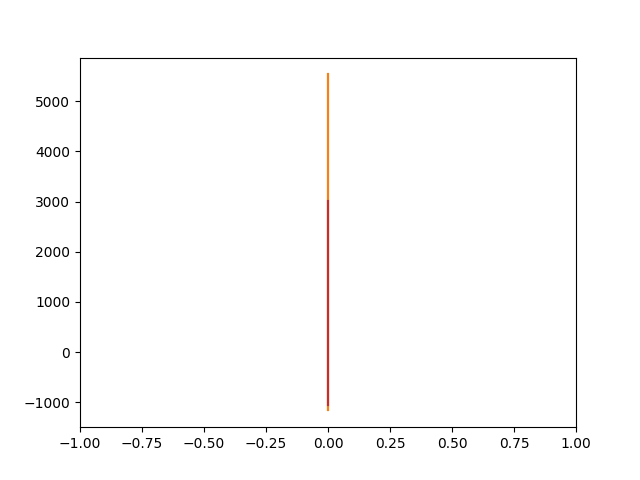

In [16]:
fig, ax = plt.subplots()
ax.plot(vect_Mn_x/10**6, vect_Pn/1000)
ax.plot(-vect_Mn_x/10**6, vect_Pn/1000)
ax.plot(vect_phi_Mn_x/10**6, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_x/10**6, vect_phi_Pn/1000)
ax.set_xlim(-1, 1)
plt.show()

<IPython.core.display.Javascript object>


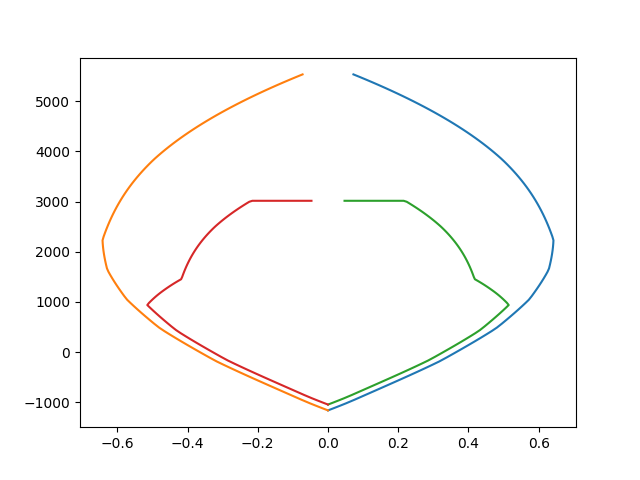

In [17]:
fig, ax = plt.subplots()
ax.plot(vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(-vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(vect_phi_Mn_y/10**6, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_y/10**6, vect_phi_Pn/1000)
plt.show()

<IPython.core.display.Javascript object>


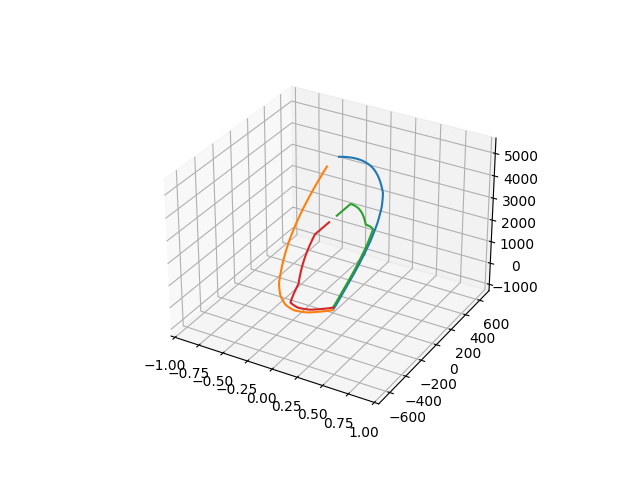

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
ax.plot(vect_Mn_x/10**3,vect_Mn_y/10**3, vect_Pn/1000)
ax.plot(-vect_Mn_x/10**3,-vect_Mn_y/10**3, vect_Pn/1000)
ax.plot(vect_phi_Mn_x/10**3,vect_phi_Mn_y/10**3, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_x/10**3,-vect_phi_Mn_y/10**3, vect_phi_Pn/1000)

## En una sóla función

In [19]:
flex_comp_data = column.nominal_PM(theta = 45)
vect_Pn = flex_comp_data[0]
vect_phi_Pn = flex_comp_data[1]
vect_Mn_x = flex_comp_data[2]
vect_phi_Mn_x = flex_comp_data[3]
vect_Mn_y = flex_comp_data[4]
vect_phi_Mn_y = flex_comp_data[5]

<IPython.core.display.Javascript object>


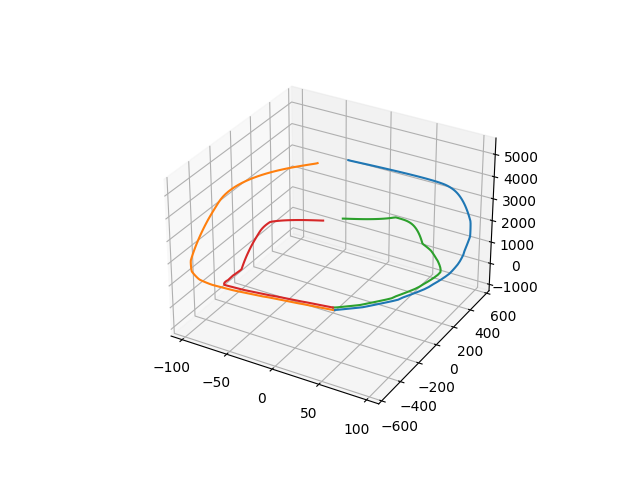

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(vect_Mn_x/10**3,vect_Mn_y/10**3, vect_Pn/1000)
ax.plot(-vect_Mn_x/10**3,-vect_Mn_y/10**3, vect_Pn/1000)
ax.plot(vect_phi_Mn_x/10**3,vect_phi_Mn_y/10**3, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_x/10**3,-vect_phi_Mn_y/10**3, vect_phi_Pn/1000)
#ax.set_ylim(-1, 1)
#ax.set_xlim(-1, 1)

## Gráfico de Flexocompresión Biaxial

In [21]:
column.biaxial_flex_comp(n_theta=30)

<IPython.core.display.Javascript object>


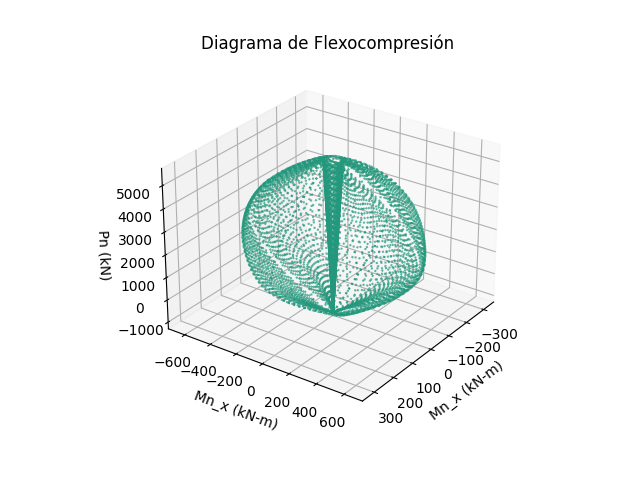

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
column.plot_bi_f_c(ax,factored=False)
    
plt.title('Diagrama de Flexocompresión')
ax.set_xlabel("Mn_x (kN-m)")
ax.set_ylabel("Mn_x (kN-m)")
ax.set_zlabel("Pn (kN)")

plt.show()

<IPython.core.display.Javascript object>


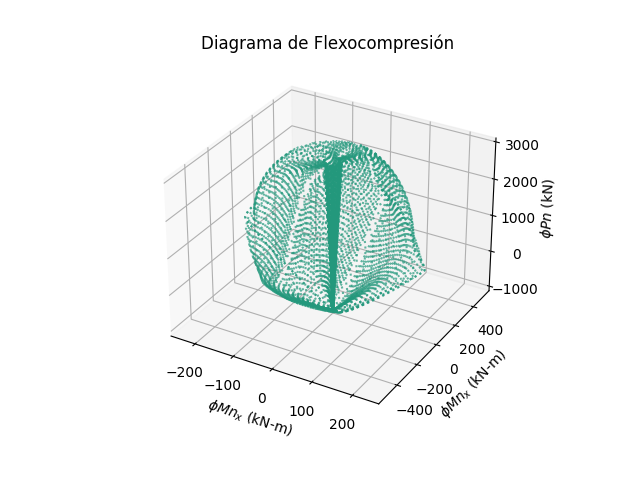

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
column.plot_bi_f_c(ax,factored=True)
    
plt.title('Diagrama de Flexocompresión')
ax.set_xlabel("$\phi Mn_x$ (kN-m)")
ax.set_ylabel("$\phi Mn_x$ (kN-m)")
ax.set_zlabel("$\phi Pn$ (kN)")
plt.show()